In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torchsummary import summary
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [12]:
transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.7),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

torch.manual_seed(42)

train_data = datasets.CIFAR10(
    root='data/',
    train=True,
    download=True,
    transform=transform_train
)

test_data = datasets.CIFAR10(
    root='data/',
    train=True,
    download=True,
    transform=transform_test
)

val_size = 10000
train_size = len(train_data) - val_size
train_data, val_data = random_split(train_data, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size = 32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


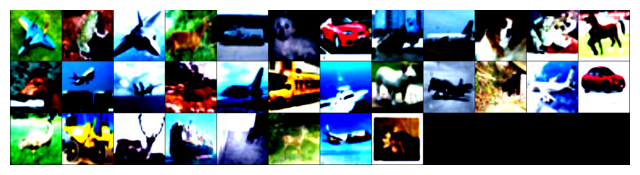

In [13]:
for images, labels in train_loader:
    plt.figure(figsize=(8,20))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=12).permute((1, 2, 0)))
    break

In [14]:
class VGG19(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block = nn.Sequential(
            nn.Linear(in_features=512 * 7 * 7, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096, out_features=1000),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=1000, out_features=num_classes)
        )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.reshape(x.shape[0], -1)
        x = self.block(x)
        return x


model = VGG19(num_classes=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)

In [15]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [16]:
from torchvision.io import read_image
from torchvision.models import vgg19, VGG19_Weights

weights = VGG19_Weights.DEFAULT
model = vgg19(weights=weights)
model.eval()

for i in range(5):
    img, label = train_data[i]
    preprocess = weights.transforms()
    batch = preprocess(img).unsqueeze(0)
    prediction = model(batch).squeeze(0).softmax(0)
    class_id = prediction.argmax().item()
    score = prediction[class_id].item()
    category_name = weights.meta["categories"][class_id]
    print(f"{category_name}: {100 * score:.1f}%")

digital clock: 78.0%
golf ball: 13.4%
harmonica: 13.4%
typewriter keyboard: 73.0%
nematode: 18.2%


### Training Custom Model

In [17]:
# from tqdm.auto import tqdm
# torch.manual_seed(42)

# epochs = 3

# def accuracy_fn(y_true, y_pred):
#     correct = torch.eq(y_true, y_pred).sum().item()
#     acc = (correct / len(y_pred)) * 100
#     return acc

# for epoch in tqdm(range(epochs)):
#     print(f"Epoch {epoch}\n-----")
#     train_loss, train_acc = 0, 0
#     model.train()
#     for batch, (X,y) in enumerate(train_loader):
#         X, y = X.to(device), y.to(device)
#         y_pred = model(X)
#         loss = loss_fn(y_pred, y)
#         train_loss += loss
#         train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     train_loss /= len(train_loader)
#     train_acc /= len(train_loader)
#     print(f"Train Loss: {train_loss:.5f} | Train Acc: {train_acc:.2f}%")

#     test_loss , test_acc = 0, 0
#     model.eval()
#     with torch.inference_mode():
#         for X, y in train_loader: # no need to keep track of batches
#             X, y = X.to(device), y.to(device)
#             test_pred = model(X)
#             test_loss += loss_fn(test_pred, y) # accumulate
#             test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1)) # convert raw outputs(logits) into labels (skipping softmax)

#         test_loss /= len(val_loader)
#         test_acc /= len(val_loader)

#     print(f"Test Loss: {test_loss:.4f} | Test acc: {test_acc:.2f}%") 

### Saving/Loading Custom Model

In [18]:
# torch.save(model.state_dict(), "cifar10_vgg16_model.pth")
# model = VGG16()
# model.load_state_dict(torch.load("cifar10_vgg16_model.pth"))
# model.eval()